In [1]:
# =============================================
# STEP 1: IMPORT LIBRARIES AND LOAD DATA
# =============================================
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline

In [2]:
# Load dataset
df = pd.read_csv('./Phishing_Email.csv')
df.head()
df.shape

(18650, 3)

In [3]:
# =============================================
# STEP 2: DATA PREPROCESSING
# =============================================

# Handle missing values (Imputation)
# Remove emails with missing labels
df = df.dropna(subset=['Email Type'])  
# Fill empty email texts with empty string
df['Email Text'] = df['Email Text'].fillna('')

In [4]:
# Text cleaning function
def replace_tags(doc):
    """Clean text by:
    1. Removing HTML line breaks
    2. Removing URLs
    3. Converting to lowercase"""
    doc = doc.replace("<br />", " ")  # Remove HTML tags
    doc = re.sub("https://\S*", "", doc)  # Remove URLs
    return doc.lower()  # Standardize text

In [5]:
# Apply cleaning to all emails
df["Email Text"] = df["Email Text"].apply(replace_tags)

In [6]:
# Bag of Words (BoW) Feature Extraction
# Converts text to numerical features by counting word frequencies
vectorizer = CountVectorizer(max_features=10_000, stop_words="english")

In [7]:
# Split data (70% training, 30% testing)
X = df['Email Text']
y = df["Email Type"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

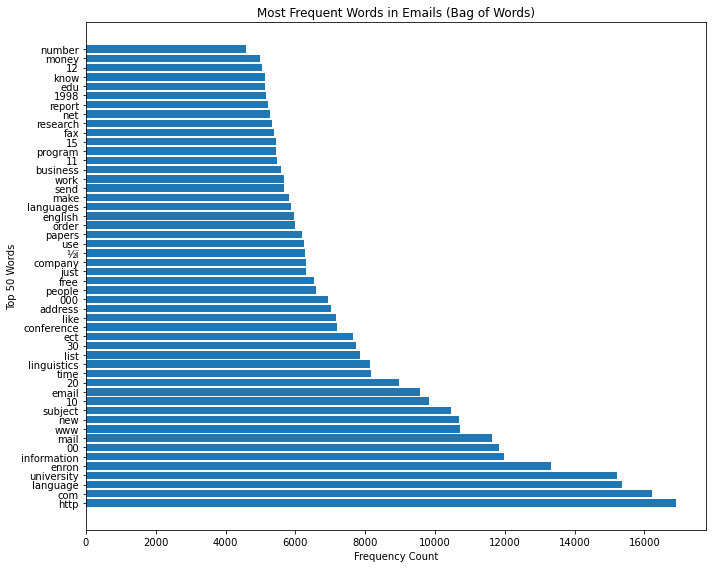

In [8]:
# =============================================
# BAG OF WORDS VISUALIZATION (UPDATED)
# =============================================

# Fit vectorizer and get word frequencies
vectorizer = CountVectorizer(max_features=50, stop_words="english")  # Top 50 words
bow_matrix = vectorizer.fit_transform(X_train)
word_counts = bow_matrix.sum(axis=0).A1  # Sum word occurrences
feature_names = vectorizer.get_feature_names_out()

# Create frequency dataframe
word_freq = pd.DataFrame({
    'Word': feature_names,
    'Frequency': word_counts
}).sort_values('Frequency', ascending=False)

# Create horizontal bar plot
plt.figure(figsize=(10, 8))
plt.barh(word_freq['Word'][::-1], word_freq['Frequency'][::-1])  # Reverse for descending order
plt.xlabel("Frequency Count")
plt.ylabel("Top 50 Words")
plt.title("Most Frequent Words in Emails (Bag of Words)")
plt.gca().invert_yaxis()  # Show highest frequency at top
plt.tight_layout()
plt.show()

In [9]:
# =============================================
# MODIFIED CODE WITH TIME TRACKING AND SVM FIX
# =============================================

# ... [keep previous imports and data loading] ...

# =============================================
# MODIFIED MODEL TRAINING SECTION WITH TIMING
# =============================================

def train_model(model, model_name):
    """Train model with time tracking"""
    start_time = time.time()
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    print(f"{model_name} trained in {training_time:.2f} seconds")
    return model, training_time

In [10]:
# Model 1: Logistic Regression
lr_pipe, lr_time = train_model(
    make_pipeline(
        CountVectorizer(max_features=10_000, stop_words="english"),
        LogisticRegression(max_iter=1000, C=0.1)
    ),
    "Logistic Regression"
)

Training Logistic Regression...
Logistic Regression trained in 3.76 seconds


In [11]:
# Model 2: Random Forest
rf_pipe, rf_time = train_model(
    make_pipeline(
        CountVectorizer(max_features=10_000, stop_words="english"),
        RandomForestClassifier(n_jobs=-1, random_state=123)
    ),
    "Random Forest"
)

Training Random Forest...
Random Forest trained in 5.53 seconds


In [12]:
# Model 3: Naive Bayes
nb_pipe, nb_time = train_model(
    make_pipeline(
        CountVectorizer(max_features=10_000, stop_words="english"),
        MultinomialNB()
    ),
    "Naive Bayes"
)

Training Naive Bayes...
Naive Bayes trained in 4.25 seconds


In [13]:
# Model 4: SVM with increased iterations
svm_pipe, svm_time = train_model(
    make_pipeline(
        CountVectorizer(max_features=10_000, stop_words="english"),
        LinearSVC(dual=False, max_iter=10000, random_state=123)  # Increased max_iter
    ),
    "SVM"
)

Training SVM...
SVM trained in 18.15 seconds


In [14]:
# Ensemble Model
ensemble, ensemble_time = train_model(
    VotingClassifier(estimators=[
        ('lr', lr_pipe),
        ('rf', rf_pipe),
        ('nb', nb_pipe),
        ('svm', svm_pipe)
    ], voting='hard'),
    "Ensemble Model"
)

Training Ensemble Model...
Ensemble Model trained in 30.89 seconds



Logistic Regression Performance:
Accuracy: 0.9675
F1 Score: 0.9605
Recall: 0.9814


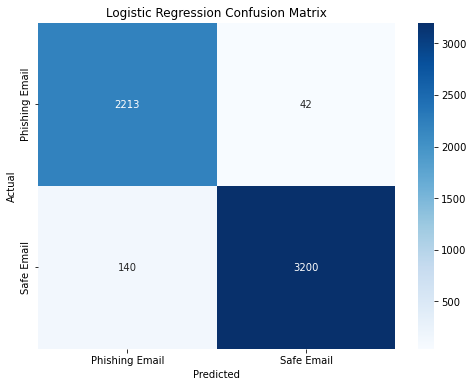


Random Forest Performance:
Accuracy: 0.9632
F1 Score: 0.9549
Recall: 0.9676


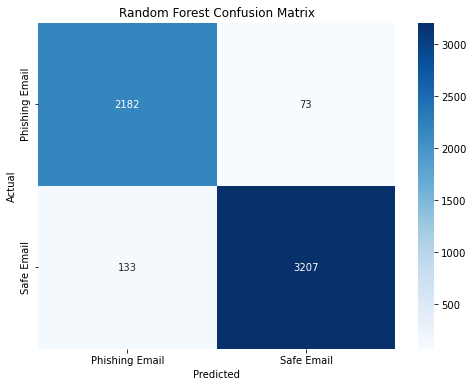


Naive Bayes Performance:
Accuracy: 0.9317
F1 Score: 0.9151
Recall: 0.9131


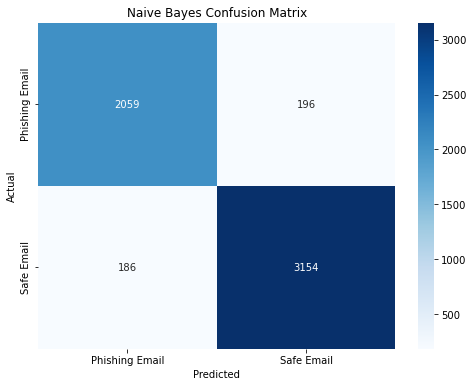


SVM Performance:
Accuracy: 0.9650
F1 Score: 0.9573
Recall: 0.9734


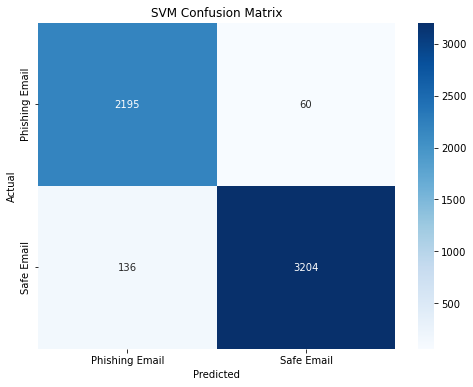


Ensemble Model Performance:
Accuracy: 0.9691
F1 Score: 0.9627
Recall: 0.9894


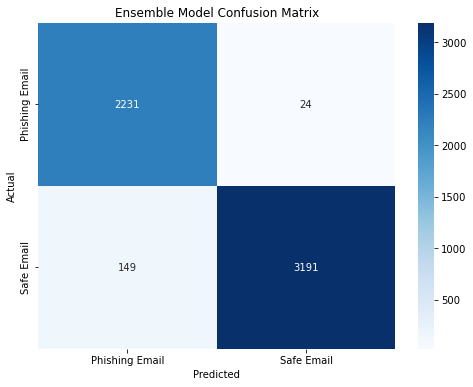

In [15]:
# =============================================
# MODEL EVALUATION FUNCTION
# =============================================

def evaluate_model(model, X_test, y_test, model_name):
    """
    Evaluates model performance and displays metrics
    Args:
        model: Trained classifier
        X_test: Test features (raw text)
        y_test: True labels
        model_name: Name for display purposes
    """
    # Generate predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, pos_label='Phishing Email')
    recall = recall_score(y_test, y_pred, pos_label='Phishing Email')
    
    # Print metrics
    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=model.classes_, 
                yticklabels=model.classes_)
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# =============================================
# EVALUATE ALL MODELS
# =============================================
models = {
    "Logistic Regression": lr_pipe,
    "Random Forest": rf_pipe,
    "Naive Bayes": nb_pipe,
    "SVM": svm_pipe,
    "Ensemble Model": ensemble
}

for name, model in models.items():
    evaluate_model(model, X_test, y_test, name)




In [16]:
# =============================================
# UPDATED CLASSIFICATION FUNCTION (4 MODELS + ENSEMBLE)
# =============================================
def classify_email():
    """
    Classifies user-input email text using all models including ensemble
    Displays predictions with visual indicators
    """
    # Get email input from user
    email_text = input("Paste the email text here: ")
    
    # Preprocess using the same cleaning function
    processed_text = replace_tags(email_text)
    
    # Get predictions from all models
    lr_pred = lr_pipe.predict([processed_text])[0]    # Logistic Regression
    rf_pred = rf_pipe.predict([processed_text])[0]    # Random Forest
    nb_pred = nb_pipe.predict([processed_text])[0]    # Naive Bayes
    svm_pred = svm_pipe.predict([processed_text])[0]  # SVM
    ensemble_pred = ensemble.predict([processed_text])[0]  # Ensemble
    
    # Display formatted results
    print("\nPrediction Results:")
    print("===================")
    print(f"Logistic Regression: {lr_pred} {'⚠️' if lr_pred == 'Phishing Email' else '✅'}")
    print(f"Random Forest:       {rf_pred} {'⚠️' if rf_pred == 'Phishing Email' else '✅'}")
    print(f"Naive Bayes:         {nb_pred} {'⚠️' if nb_pred == 'Phishing Email' else '✅'}")
    print(f"SVM:                 {svm_pred} {'⚠️' if svm_pred == 'Phishing Email' else '✅'}")
    print("-" * 20)
    print(f"Final Ensemble:      {ensemble_pred} {'⚠️' if ensemble_pred == 'Phishing Email' else '✅'} (Majority Vote)")
    print("===================")

# Example usage
classify_email()
#example of phishing email:
#Your account needs verification. Click immediately: http://phishy.link

Paste the email text here: Your account needs verification. Click immediately: http://phishy.link

Prediction Results:
Logistic Regression: Phishing Email ⚠️
Random Forest:       Phishing Email ⚠️
Naive Bayes:         Phishing Email ⚠️
SVM:                 Phishing Email ⚠️
--------------------
Final Ensemble:      Phishing Email ⚠️ (Majority Vote)


In [18]:
# =============================================
# COMPARATIVE RESULTS TABLE
# =============================================
# Initialize results storage
results = []

def evaluate_model(model, X_test, y_test, model_name, training_time):
    """Modified to return metrics instead of printing"""
    y_pred = model.predict(X_test)
    
    return {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred, pos_label='Phishing Email'),
        'Recall': recall_score(y_test, y_pred, pos_label='Phishing Email'),
        'Training Time (s)': training_time
    }

# Evaluate all models
model_data = [
    (lr_pipe, "Logistic Regression", lr_time),
    (rf_pipe, "Random Forest", rf_time),
    (nb_pipe, "Naive Bayes", nb_time),
    (svm_pipe, "SVM", svm_time),
    (ensemble, "Ensemble", ensemble_time)
]

for model, name, time in model_data:
    results.append(evaluate_model(model, X_test, y_test, name, time))

# Create DataFrame with formatted values
results_df = pd.DataFrame(results).sort_values('Accuracy', ascending=False)
results_df = results_df.round(4)
results_df['Training Time (s)'] = results_df['Training Time (s)'].round(2)

# Add ranking column
results_df['Rank'] = results_df['Accuracy'].rank(ascending=False).astype(int)

# Print formatted table
print("\nModel Performance Comparison:")
print("="*65)
print(results_df.to_string(index=False))
print("="*65)

# Optional: Highlight best in each category
print("\nBest Performers:")
print(f"• Highest Accuracy: {results_df.loc[results_df['Accuracy'].idxmax(), 'Model']}")
print(f"• Best F1 Score: {results_df.loc[results_df['F1 Score'].idxmax(), 'Model']}")
print(f"• Fastest Training: {results_df.loc[results_df['Training Time (s)'].idxmin(), 'Model']}")


Model Performance Comparison:
              Model  Accuracy  F1 Score  Recall  Training Time (s)  Rank
           Ensemble    0.9691    0.9627  0.9894              30.89     1
Logistic Regression    0.9675    0.9605  0.9814               3.76     2
                SVM    0.9650    0.9573  0.9734              18.15     3
      Random Forest    0.9632    0.9549  0.9676               5.53     4
        Naive Bayes    0.9317    0.9151  0.9131               4.25     5

Best Performers:
• Highest Accuracy: Ensemble
• Best F1 Score: Ensemble
• Fastest Training: Logistic Regression
